In [1]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
def get_real_estate_type(soup, s):
    real_estate_types = ['Căn hộ chung cư',
        'Chung cư mini, căn hộ dịch vụ',
        'Nhà riêng',
        'Nhà biệt thự, liền kề',
        'Nhà mặt phố',
        'Shophouse, nhà phố thương mại',
        'Đất nền dự án',
        'Bán đất',
        'Trang trại, khu nghỉ dưỡng',
        'Condotel',
        'Kho, nhà xưởng',
        'Loại bất động sản khác']

    
    for item in real_estate_types:
        if item in s:
            return item
    return None



def get_details(soup):
    content_items = soup.find_all('div', class_="re__pr-specs-content-item")
    content = {}
    for item in content_items:
        key = item.find('span', class_='re__pr-specs-content-item-title').text
        value = item.find('span', class_='re__pr-specs-content-item-value').text
        content[key] = value

    content['Khu vực'] = soup.find('a', {'level': '3'}).text
    try:
        content['Loại bất động sản'] = get_real_estate_type(soup, soup.find('a', {'level': '4'}).text)
    except:
        content['Loại bất động sản'] = None

    return content

In [3]:
html_files = glob.glob('data/*.html')

feature_names = []
list_post_details = []
for html_file in html_files:
    with open(html_file, "r", encoding="utf-8") as file:
        content = file.read()

    soup = BeautifulSoup(content, 'html.parser')
    content = get_details(soup)
    list_post_details.append(content)
    
    for item in content:
        if item not in feature_names:
            feature_names.append(item)



In [4]:
feature_names


['Diện tích',
 'Mức giá',
 'Mặt tiền',
 'Đường vào',
 'Số tầng',
 'Pháp lý',
 'Nội thất',
 'Khu vực',
 'Loại bất động sản',
 'Hướng nhà',
 'Hướng ban công',
 'Số phòng ngủ',
 'Số toilet']

In [5]:
df = pd.DataFrame(columns=feature_names)
new_rows_df = pd.DataFrame(list_post_details)
df = pd.concat([df, new_rows_df], ignore_index=True)
df.to_csv('unclean_data.csv', index=False)

In [6]:
print(df.shape)
df.head()

(37, 13)


,Diện tích,Mức giá,Mặt tiền,Đường vào,Số tầng,Pháp lý,Nội thất,Khu vực,Loại bất động sản,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,64 m²,"14,9 tỷ","3,9 m",10 m,1 tầng,Sổ đỏ/ Sổ hồng,Cơ bản,Hà Đông,Nhà mặt phố,NaN,NaN,NaN,NaN
1,63 m²,65 triệu/m²,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Cơ bản,Nam Từ Liêm,Căn hộ chung cư,Tây - Bắc,Đông - Nam,2 phòng,2 phòng
2,55 m²,"4,4 tỷ",NaN,NaN,NaN,Hợp đồng mua bán.,"Đầy đủ - Nội thất full đồ rời cao cấp, mới đập...",Nam Từ Liêm,Căn hộ chung cư,Tây - Nam,Đông - Bắc,2 phòng,2 phòng
3,83 m²,"5,2 tỷ",NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,Nam Từ Liêm,Căn hộ chung cư,Đông - Nam,Tây - Bắc,3 phòng,2 phòng
4,136 m²,"8,8 tỷ",NaN,NaN,NaN,"Sổ đỏ cất két, sẵn sàng giao dịch.","Đầy đủ nội thất. Nội thất nhập khẩu đầy đủ, ch...",Nam Từ Liêm,Căn hộ chung cư,NaN,NaN,4 phòng,3 phòng


In [7]:
non_empty_counts = df.count()
print(non_empty_counts)

Diện tích            37
Mức giá              37
Mặt tiền             17
Đường vào            13
Số tầng              18
Pháp lý              32
Nội thất             25
Khu vực              37
Loại bất động sản    37
Hướng nhà            14
Hướng ban công       11
Số phòng ngủ         29
Số toilet            28
dtype: int64


In [8]:
def extract_float(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+(\.\d+)?', s)
    if match:
        return float(match.group())
    return None


def extract_integer(s):
    if not s:
        return None
    if pd.isna(s):
        return None
    match = re.search(r'\d+', s)
    if match:
        return int(match.group())
    return None

def convert_price_to_billion(price_str):
    if not price_str:
        return None
    if pd.isna(price_str):
        return None
    if price_str == 'Thỏa thuận':
        return None
    price_str = price_str.lower()
    pattern = re.findall(r'(\d+(?:,\d+)?)\s*(tỷ|triệu)', price_str)
    total_price_in_billion = 0
    for value, unit in pattern:
        value = float(value.replace(',', '.'))
        if unit == "tỷ":
            total_price_in_billion += value
        elif unit == "triệu":
            total_price_in_billion += value / 1000
    return total_price_in_billion

In [9]:
new_df = df.copy()

new_df['Diện tích'] = new_df['Diện tích'].apply(extract_float)
new_df['Mức giá'] = new_df['Mức giá'].apply(convert_price_to_billion)
new_df['Đường vào'] = new_df['Đường vào'].apply(extract_float)
new_df['Mặt tiền'] = new_df['Mặt tiền'].apply(extract_float)
new_df['Số phòng ngủ'] = new_df['Số phòng ngủ'].apply(extract_integer)
new_df['Số toilet'] = new_df['Số toilet'].apply(extract_integer)
new_df['Số tầng'] = new_df['Số tầng'].apply(extract_integer)


In [10]:
print(new_df.shape)
new_df.head()

(37, 13)


,Diện tích,Mức giá,Mặt tiền,Đường vào,Số tầng,Pháp lý,Nội thất,Khu vực,Loại bất động sản,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,64.0,14.900,3.0,10.0,1.0,Sổ đỏ/ Sổ hồng,Cơ bản,Hà Đông,Nhà mặt phố,NaN,NaN,NaN,NaN
1,63.0,0.065,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Cơ bản,Nam Từ Liêm,Căn hộ chung cư,Tây - Bắc,Đông - Nam,2.0,2.0
2,55.0,4.400,NaN,NaN,NaN,Hợp đồng mua bán.,"Đầy đủ - Nội thất full đồ rời cao cấp, mới đập...",Nam Từ Liêm,Căn hộ chung cư,Tây - Nam,Đông - Bắc,2.0,2.0
3,83.0,5.200,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,Nam Từ Liêm,Căn hộ chung cư,Đông - Nam,Tây - Bắc,3.0,2.0
4,136.0,8.800,NaN,NaN,NaN,"Sổ đỏ cất két, sẵn sàng giao dịch.","Đầy đủ nội thất. Nội thất nhập khẩu đầy đủ, ch...",Nam Từ Liêm,Căn hộ chung cư,NaN,NaN,4.0,3.0


In [11]:
new_df.dropna(subset=['Mức giá'], inplace=True)
print(new_df.shape)
new_df.head(10)

(34, 13)


,Diện tích,Mức giá,Mặt tiền,Đường vào,Số tầng,Pháp lý,Nội thất,Khu vực,Loại bất động sản,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,64.0,14.900,3.0,10.0,1.0,Sổ đỏ/ Sổ hồng,Cơ bản,Hà Đông,Nhà mặt phố,NaN,NaN,NaN,NaN
1,63.0,0.065,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Cơ bản,Nam Từ Liêm,Căn hộ chung cư,Tây - Bắc,Đông - Nam,2.0,2.0
2,55.0,4.400,NaN,NaN,NaN,Hợp đồng mua bán.,"Đầy đủ - Nội thất full đồ rời cao cấp, mới đập...",Nam Từ Liêm,Căn hộ chung cư,Tây - Nam,Đông - Bắc,2.0,2.0
3,83.0,5.200,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,Nam Từ Liêm,Căn hộ chung cư,Đông - Nam,Tây - Bắc,3.0,2.0
4,136.0,8.800,NaN,NaN,NaN,"Sổ đỏ cất két, sẵn sàng giao dịch.","Đầy đủ nội thất. Nội thất nhập khẩu đầy đủ, ch...",Nam Từ Liêm,Căn hộ chung cư,NaN,NaN,4.0,3.0
6,21.0,2.980,3.0,NaN,3.0,Sổ đỏ/ Sổ hồng,NaN,Thanh Xuân,Nhà riêng,NaN,NaN,NaN,NaN
7,75.0,5.500,NaN,NaN,NaN,Hợp đồng mua bán,Đầy đủ,Nam Từ Liêm,Căn hộ chung cư,Tây - Nam,Đông - Bắc,3.0,2.0
8,116.0,4.980,NaN,NaN,NaN,NaN,NaN,Long Biên,Căn hộ chung cư,NaN,NaN,3.0,2.0
9,38.0,2.200,4.0,3.0,3.0,Sổ đỏ/ Sổ hồng,Cơ bản,Thanh Oai,Nhà riêng,Tây,NaN,3.0,3.0
10,136.0,7.300,NaN,NaN,NaN,NaN,NaN,Hoài Đức,Căn hộ chung cư,NaN,NaN,4.0,3.0


In [12]:
encode_df = new_df.copy()

encode_df['Hướng nhà'] = encode_df['Hướng nhà'].astype('category').cat.codes
encode_df['Hướng ban công'] = encode_df['Hướng ban công'].astype('category').cat.codes
encode_df['Pháp lý'] = encode_df['Pháp lý'].astype('category').cat.codes
encode_df['Nội thất'] = encode_df['Nội thất'].astype('category').cat.codes
encode_df['Khu vực'] = encode_df['Khu vực'].astype('category').cat.codes
encode_df['Loại bất động sản'] = encode_df['Loại bất động sản'].astype('category').cat.codes



In [13]:
print(encode_df.shape)
encode_df.head(10)

(34, 13)


,Diện tích,Mức giá,Mặt tiền,Đường vào,Số tầng,Pháp lý,Nội thất,Khu vực,Loại bất động sản,Hướng nhà,Hướng ban công,Số phòng ngủ,Số toilet
0,64.0,14.900,3.0,10.0,1.0,5,0,7,3,-1,-1,NaN,NaN
1,63.0,0.065,NaN,NaN,NaN,5,0,9,1,2,4,2.0,2.0
2,55.0,4.400,NaN,NaN,NaN,2,3,9,1,3,3,2.0,2.0
3,83.0,5.200,NaN,NaN,NaN,5,2,9,1,5,1,3.0,2.0
4,136.0,8.800,NaN,NaN,NaN,3,4,9,1,-1,-1,4.0,3.0
6,21.0,2.980,3.0,NaN,3.0,5,-1,11,4,-1,-1,NaN,NaN
7,75.0,5.500,NaN,NaN,NaN,1,2,9,1,3,3,3.0,2.0
8,116.0,4.980,NaN,NaN,NaN,-1,-1,8,1,-1,-1,3.0,2.0
9,38.0,2.200,4.0,3.0,3.0,5,0,10,4,1,-1,3.0,3.0
10,136.0,7.300,NaN,NaN,NaN,-1,-1,5,1,-1,-1,4.0,3.0


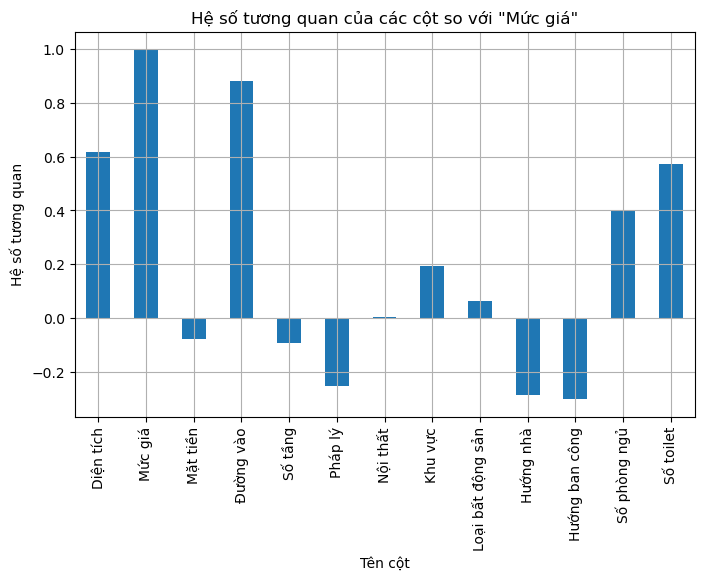

In [14]:
correlations = encode_df.corr()['Mức giá']

plt.figure(figsize=(8, 5))
correlations.plot(kind='bar')

plt.title('Hệ số tương quan của các cột so với "Mức giá"')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Tên cột')
plt.grid(True)
plt.show()

In [15]:
encode_df = encode_df.drop(columns=['Hướng nhà', 'Hướng ban công', 'Pháp lý', 'Nội thất'])
encode_df = encode_df.dropna()
encode_df.to_csv('cleaned_data.csv', index=False)


In [16]:
encode_df.shape

(8, 9)

In [17]:
unique_values = df['Loại bất động sản'].unique()
unique_values

array(['Nhà mặt phố', 'Căn hộ chung cư', 'Nhà riêng', 'Bán đất',
       'Nhà biệt thự, liền kề'], dtype=object)

In [18]:
unique_values = df['Khu vực'].unique()
unique_values

array(['Hà Đông', 'Nam Từ Liêm', 'Thanh Xuân', 'Long Biên', 'Thanh Oai',
       'Hoài Đức', 'Cầu Giấy', 'Hai Bà Trưng', 'Tây Hồ', 'Quốc Oai',
       'Chương Mỹ', 'Hoàng Mai', 'Đông Anh', 'Ba Đình', 'Bắc Từ Liêm'],
      dtype=object)